In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Input, LSTM, BatchNormalization, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
from numpy.lib.stride_tricks import sliding_window_view
from tensorflow.keras.regularizers import l2

import warnings
warnings.simplefilter(action='ignore')


In [2]:
data = pd.read_excel('/content/power data.xls')
data.head()

,time,power
0,15.01.2021 0:00,77.04
1,15.01.2021 1:00,81.18
2,15.01.2021 2:00,96.60
3,15.01.2021 3:00,107.94
4,15.01.2021 4:00,128.52


In [3]:
data['time'] = pd.to_datetime(data['time'])


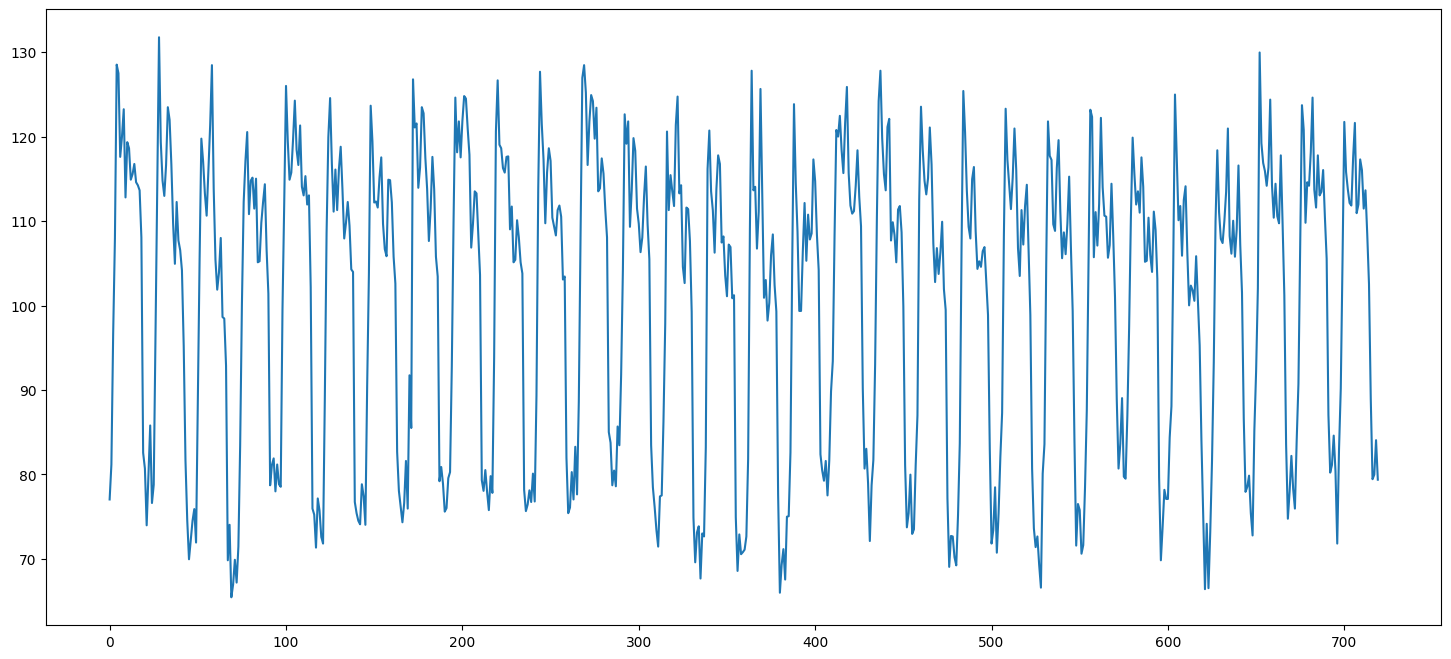

In [4]:
#первый месяц
plt.figure(figsize=(18, 8))
plt.plot(data['power'][:720])
plt.show()

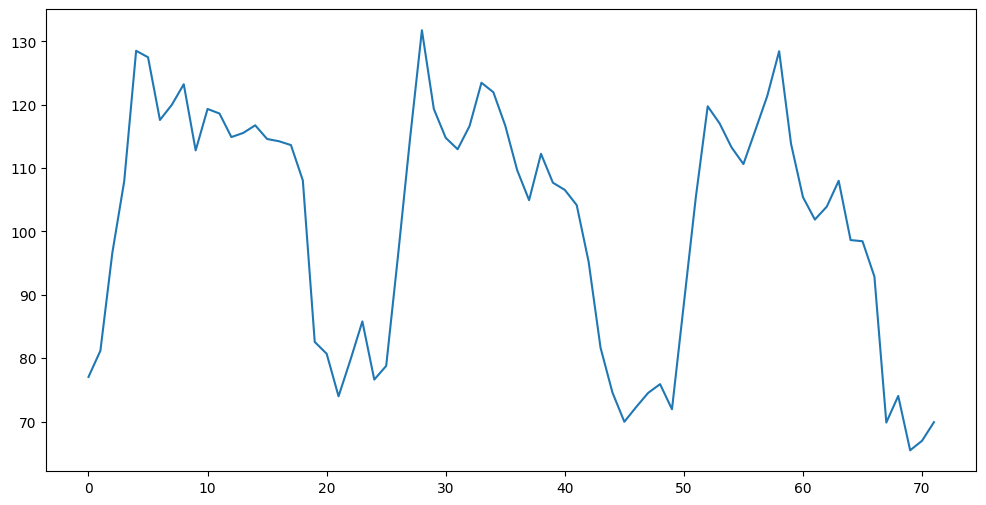

In [5]:
#первые три дня
plt.figure(figsize=(12, 6))
plt.plot(data['power'][:72])
plt.show()

In [6]:
data.set_index('time', inplace=True)


In [7]:
data.head()

,power
time,
2021-01-15 00:00:00,77.04
2021-01-15 01:00:00,81.18
2021-01-15 02:00:00,96.60
2021-01-15 03:00:00,107.94
2021-01-15 04:00:00,128.52


In [8]:
data.shape

(30312, 1)

In [9]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
power,30312.0,117.054826,44.474912,0.0,88.56,117.36,134.46,503.4


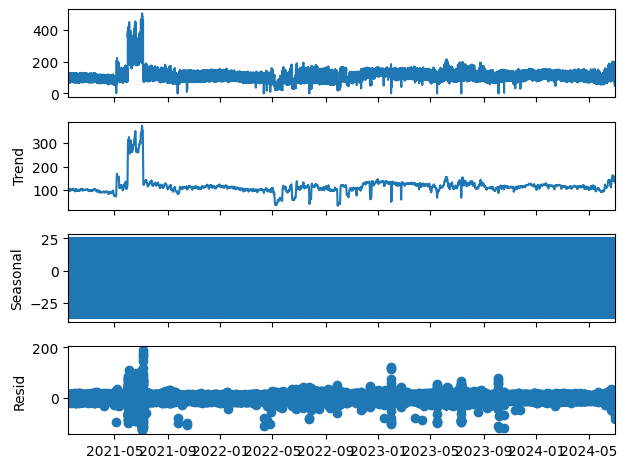

In [10]:
decompose = seasonal_decompose(data, model='additive')
decompose.plot()

plt.show()

график стабилен, имеет горизонтальный тренд

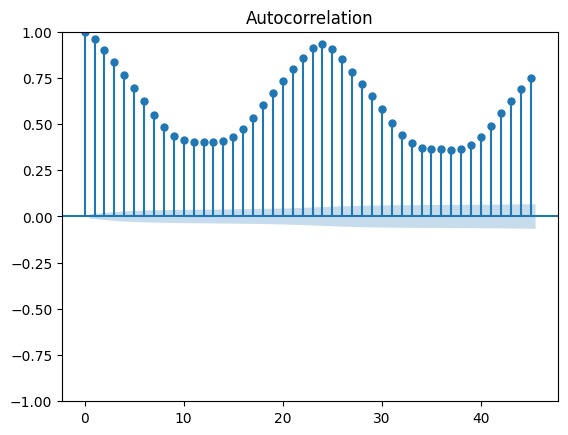

In [11]:
#автокорреляция
plot_acf(data)
plt.show()

In [12]:
#проверим стационарность
result = adfuller(data['power'])

print(f'p-value = {result[1]}')


p-value = 1.1636898628494618e-08


In [13]:
train = data[:'2021-10-15']
test = data['2021-10-16':'2022-01-16']

In [14]:
test.tail()

,power
time,
2022-01-16 19:00:00,80.46
2022-01-16 20:00:00,82.68
2022-01-16 21:00:00,78.36
2022-01-16 22:00:00,78.66
2022-01-16 23:00:00,81.60


In [15]:
#модель sarima, в качестве сезонности укажем сутки(24 часа)
model_sarima = SARIMAX(train,
                order=(1, 1, 2),
                seasonal_order=(1, 1, 2, 24))

result = model_sarima.fit()

print(result.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              power   No. Observations:                 6576
Model:             SARIMAX(1, 1, 2)x(1, 1, 2, 24)   Log Likelihood              -23310.451
Date:                            Mon, 18 Nov 2024   AIC                          46634.902
Time:                                    06:03:17   BIC                          46682.414
Sample:                                01-15-2021   HQIC                         46651.329
                                     - 10-15-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5498      0.052    -10.514      0.000      -0.652      -0.447
ma.L1          0.4284      0.052   

In [16]:

predictions = result.forecast(len(test))
predictions



,predicted_mean
2021-10-16 00:00:00,75.981850
2021-10-16 01:00:00,81.290652
2021-10-16 02:00:00,92.897729
2021-10-16 03:00:00,113.069617
2021-10-16 04:00:00,137.040460
...,...
2022-01-16 19:00:00,86.502453
2022-01-16 20:00:00,79.371590
2022-01-16 21:00:00,76.273446
2022-01-16 22:00:00,77.394835


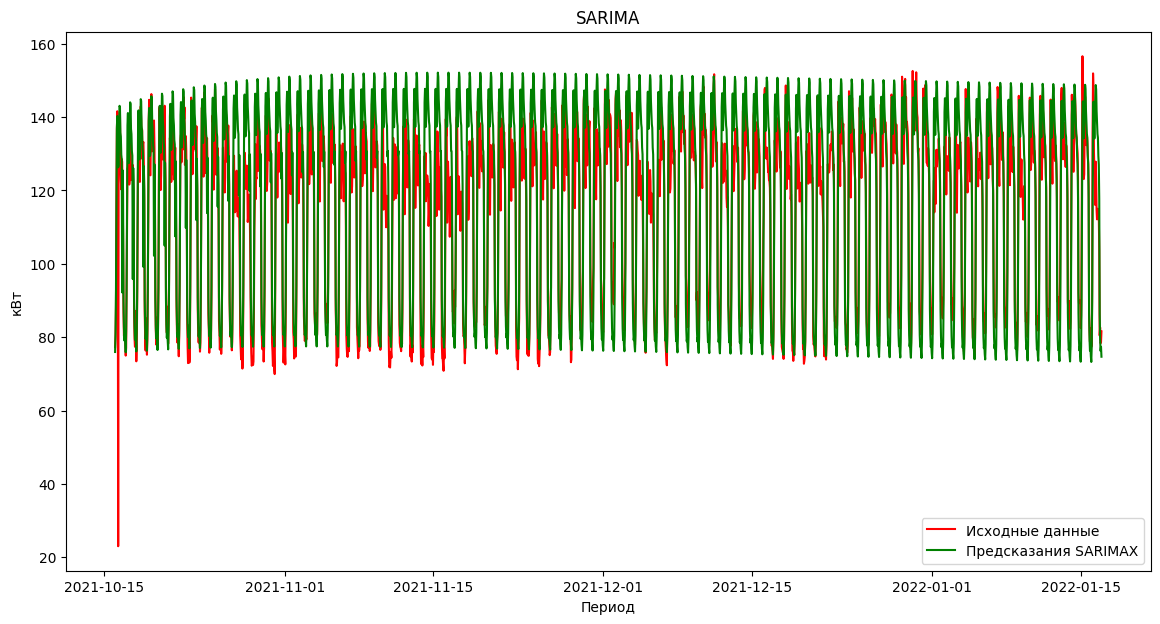

In [17]:
#визуализируем результат
plt.figure(figsize=(14, 7))
plt.plot(test, label='Исходные данные', color='red')
plt.plot(predictions, label='Предсказания SARIMAX', color='green')

plt.title('SARIMA')
plt.ylabel('кВт')
plt.xlabel('Период')
plt.legend()

plt.show()

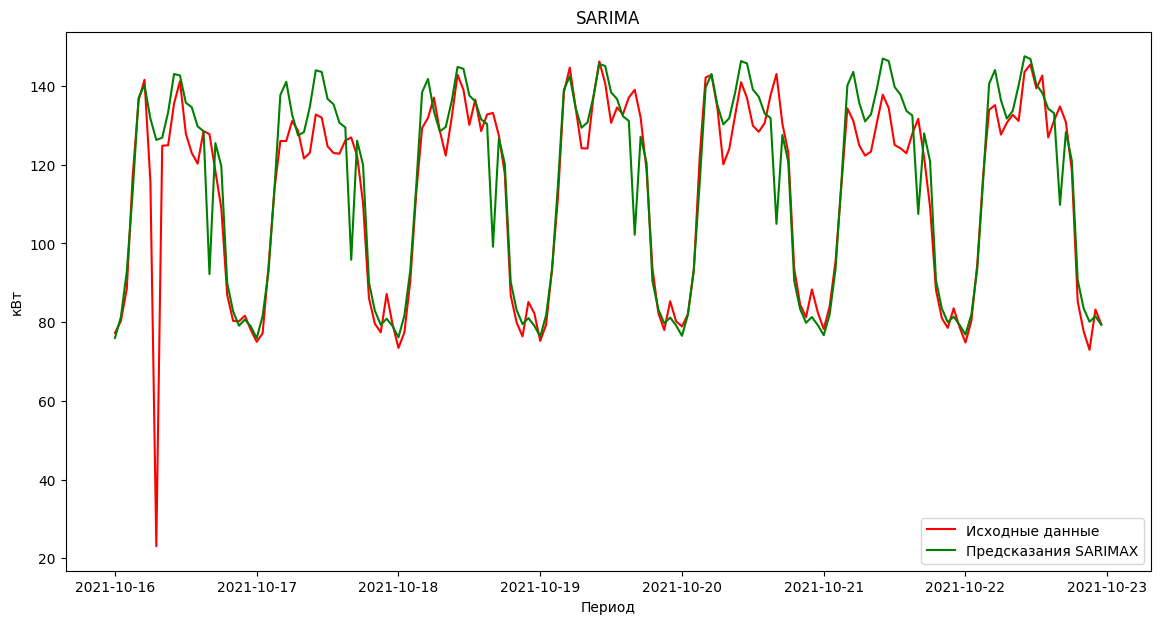

In [133]:
#визуализируем результат за неделю
plt.figure(figsize=(14, 7))
plt.plot(test[:168], label='Исходные данные', color='red')
plt.plot(predictions[:168], label='Предсказания SARIMAX', color='green')

plt.title('SARIMA')
plt.ylabel('кВт')
plt.xlabel('Период')
plt.legend()

plt.show()

In [19]:
print(f'RMSE: {mean_squared_error(predictions, test, squared=False)}')
print(f'MAE: {mean_absolute_error(predictions, test)}')
print(f'MAPE: {mean_absolute_percentage_error(predictions, test)}')
print(f'R2: {r2_score(predictions, test)}')

RMSE: 11.012962819089168
MAE: 8.50330492089739
MAPE: 0.0704909805659586
R2: 0.838944687362444


In [20]:
#посмотрим на данные
res_sarima = pd.DataFrame({'прогноз': predictions, 'факт': np.array(test).flatten()})
res_sarima.head()

,прогноз,факт
2021-10-16 00:00:00,75.981850,77.28
2021-10-16 01:00:00,81.290652,80.28
2021-10-16 02:00:00,92.897729,88.44
2021-10-16 03:00:00,113.069617,117.12
2021-10-16 04:00:00,137.040460,136.38


In [21]:
train['power'] = train['power'].replace(0, 0.0001) #заменим нулевые значения для экспоненциального сглаживания

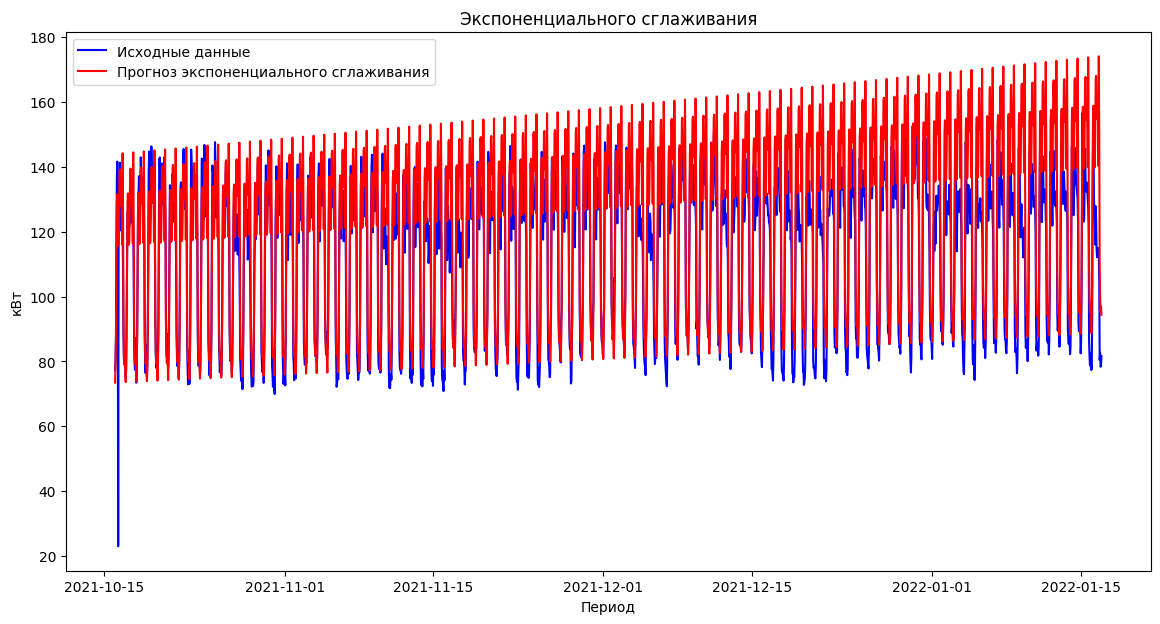

In [22]:
# Экспоненциальное сглаживание
exp_smoothing_model = ExponentialSmoothing(train, trend='mul', seasonal='mul', seasonal_periods=24)
exp_smoothing_results = exp_smoothing_model.fit()

exp_smoothing_forecast = exp_smoothing_results.forecast(steps=len(test))

plt.figure(figsize=(14, 7))
plt.plot(test, label='Исходные данные', color='blue')
plt.plot(exp_smoothing_forecast, label='Прогноз экспоненциального сглаживания', color='red')
plt.title('Экспоненциального сглаживания')
plt.xlabel('Период')
plt.ylabel('кВт')
plt.legend()
plt.show()


In [23]:
print(f'RMSE: {mean_squared_error(exp_smoothing_forecast, test, squared=False)}')
print(f'MAE: {mean_absolute_error(exp_smoothing_forecast, test)}')
print(f'MAPE: {mean_absolute_percentage_error(exp_smoothing_forecast, test)}')
print(f'R2: {r2_score(exp_smoothing_forecast, test)}')

RMSE: 14.289817956037837
MAE: 10.761804787190295
MAPE: 0.08298373215205276
R2: 0.7042611331352531


Экспоненциальное сглаживание не улучшело результаты

In [24]:

res_ex = pd.DataFrame({'прогноз': exp_smoothing_forecast, 'факт': np.array(test).flatten()})

res_ex.head()

,прогноз,факт
2021-10-16 00:00:00,73.482250,77.28
2021-10-16 01:00:00,79.140786,80.28
2021-10-16 02:00:00,87.961655,88.44
2021-10-16 03:00:00,107.927093,117.12
2021-10-16 04:00:00,128.584999,136.38


RNN

In [25]:
#разделим на трейн и тест (80/20)
df = data['power']
n = len(df)
size = int(n*0.8)
train_data = df[range(size)]
test_data = df[size:]

In [26]:
time_steps = 72 #возьмем 3 дня (72 часа) в качестве временного шага

#функция для преобразования входных данных
def get_x_y(data, time_steps):
    X = sliding_window_view(np.array(data), window_shape=time_steps)
    X = X[:-1, :]
    X = X.reshape(X.shape[0], time_steps, 1)
    y = data[time_steps:]
    return X, y

X_train, y_train = get_x_y(train_data, time_steps)
X_test, y_test = get_x_y(test_data, time_steps)

In [27]:
#архитектура рекуррентной инс
model_rnn = Sequential()
model_rnn.add(Input(shape=(time_steps,1)))
model_rnn.add(SimpleRNN(100, activation='linear'))
model_rnn.add(Dropout(0.1))
model_rnn.add(Dense(64, activation='linear'))
model_rnn.add(Dropout(0.1))
model_rnn.add(Dense(32, activation='linear'))
model_rnn.add(Dropout(0.1))
model_rnn.add(Dense(1, activation='linear'))

optimizer = Adam()

model_rnn.compile(optimizer=optimizer, loss='mean_squared_error')

e_stop = EarlyStopping(patience=8, restore_best_weights=True)

history_rnn = model_rnn.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1, validation_split=0.1, callbacks=[e_stop])


Epoch 1/10
680/680 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 5129.9751 - val_loss: 105.4805
Epoch 2/10
680/680 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 357.9084 - val_loss: 65.7172
Epoch 3/10
680/680 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - loss: 295.6671 - val_loss: 89.1916
Epoch 4/10
680/680 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - loss: 266.8703 - val_loss: 61.5973
Epoch 5/10
680/680 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - loss: 236.5915 - val_loss: 59.5662
Epoch 6/10
680/680 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - loss: 220.5586 - val_loss: 100.9804
Epoch 7/10
680/680 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - loss: 205.7204 - val_loss: 61.3201
Epoch 8/10
680/680 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - loss: 212.4648 - val_loss: 64.5662
Epoch 9/10
680/680 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - loss: 198.9417 - val_loss: 70.4988
Epoch 10/10
680/680 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - loss: 199.6214 - val_loss: 179.0133


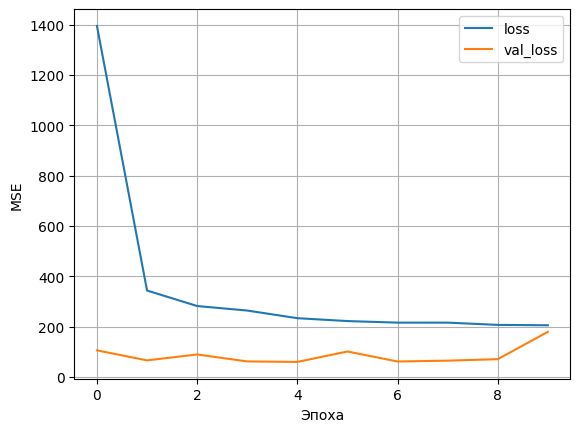

In [28]:
plt.plot(history_rnn.history['loss'], label='loss')
plt.plot(history_rnn.history['val_loss'], label='val_loss')
plt.xlabel('Эпоха')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.show()


In [29]:
predict_rnn = model_rnn.predict(X_test)

188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [30]:
print(f'RMSE: {mean_squared_error(predict_rnn, y_test, squared=False)}')
print(f'MAE: {mean_absolute_error(predict_rnn, y_test)}')
print(f'MAPE: {mean_absolute_percentage_error(predict_rnn, y_test)}')
print(f'R2: {r2_score(predict_rnn, y_test)}')

RMSE: 5.965972668833875
MAE: 4.386543369843991
MAPE: 0.04010335547016169
R2: 0.9389378945753588


Хороший результат, модель в среднем ошибается на 5 кВт

LSTM

In [32]:
model_lstm = Sequential()
model_lstm.add(Input(shape=(time_steps,1)))
model_lstm.add(LSTM(10, activation='linear'))
model_lstm.add(Dropout(0.2))
#model_lstm.add(Dense(8, activation='linear'))
#model_lstm.add(Dropout(0.5))
model_lstm.add(Dense(5, activation='linear'))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(1, activation='linear'))

optimizer = Adam(learning_rate=0.001)

model_lstm.compile(optimizer=optimizer, loss='mean_squared_error')

e_stop = EarlyStopping(patience=8, restore_best_weights=True)

history_model_lstm = model_lstm.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1, validation_split=0.1, callbacks=[e_stop])

Epoch 1/10
680/680 ━━━━━━━━━━━━━━━━━━━━ 28s 32ms/step - loss: 10986.4365 - val_loss: 1735.0035
Epoch 2/10
680/680 ━━━━━━━━━━━━━━━━━━━━ 37s 26ms/step - loss: 3920.0762 - val_loss: 503644320.0000
Epoch 3/10
680/680 ━━━━━━━━━━━━━━━━━━━━ 24s 32ms/step - loss: 4384.5439 - val_loss: 6957.9033
Epoch 4/10
680/680 ━━━━━━━━━━━━━━━━━━━━ 36s 24ms/step - loss: 6436.3218 - val_loss: 1814.8499
Epoch 5/10
680/680 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - loss: 4656.2358 - val_loss: 1604.9342
Epoch 6/10
680/680 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - loss: 4520.4966 - val_loss: 1647.6461
Epoch 7/10
680/680 ━━━━━━━━━━━━━━━━━━━━ 19s 28ms/step - loss: 4412.2485 - val_loss: 1554.8080
Epoch 8/10
680/680 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - loss: 4327.5542 - val_loss: 1555.6674
Epoch 9/10
680/680 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - loss: 4233.0010 - val_loss: 1455.7891
Epoch 10/10
680/680 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - loss: 4068.1526 - val_loss: 1528.5302


In [33]:
predict_lstm = model_lstm.predict(X_test)

print(f'RMSE: {mean_squared_error(predict_lstm, y_test, squared=False)}')
print(f'MAE: {mean_absolute_error(predict_lstm, y_test)}')
print(f'MAPE: {mean_absolute_percentage_error(predict_lstm, y_test)}')
print(f'R2: {r2_score(predict_lstm, y_test)}')

188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
RMSE: 37.68826241873106
MAE: 32.56603290224848
MAPE: 0.375210757454479
R2: -25.690817114351027


LSTM мимо

Т.к. задачей было прогнозировать на сутки вперед, необходимо чтобы на выходе получали 24 значения. Проведем доработку и протестим на RNN модели

In [213]:
forecast_horizon = 24 #переменная для 24 значений на выходе


#функция для преобразования данных на вход
def get_x_y_24(data, time_steps, forecast_horizon):
    data_array = np.array(data)
    n_samples = len(data_array) - time_steps - forecast_horizon + 1
    X = sliding_window_view(data_array, window_shape=(time_steps,))[:-forecast_horizon]
    X = X.reshape(-1, time_steps, 1)
    y = np.array([data_array[i + time_steps:i + time_steps + forecast_horizon] for i in range(n_samples)])
    return X, y

X_train, y_train = get_x_y_24(train_data, time_steps, forecast_horizon)
X_test, y_test = get_x_y_24(test_data, time_steps, forecast_horizon)

In [287]:
#доработаем ИНС

model_rnn = Sequential()
model_rnn.add(Input(shape=(time_steps,1)))
model_rnn.add(SimpleRNN(100, activation='linear'))
model_rnn.add(Dropout(0.4)) #оставим один слой dropout со значением 0.4
model_rnn.add(Dense(64, activation='linear'))
#model_rnn.add(Dropout(0.1))
model_rnn.add(Dense(32, activation='linear'))
#model_rnn.add(Dropout(0.1))
model_rnn.add(Dense(32, activation='linear'))
#model_rnn.add(Dropout(0.1))
model_rnn.add(Dense(forecast_horizon, activation='linear')) #24 нейрона на выходе

optimizer = Adam(0.0001) #уменьшим скорость обучения

model_rnn.compile(optimizer=optimizer, loss='mean_squared_error')

e_stop = EarlyStopping(patience=8, restore_best_weights=True)

history_rnn = model_rnn.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1, validation_split=0.1, callbacks=[e_stop]) #увеличим кол-во эпох

predict_rnn = model_rnn.predict(X_test)

Epoch 1/20
680/680 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - loss: 6395.9600 - val_loss: 552.3253
Epoch 2/20
680/680 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - loss: 1163.2219 - val_loss: 312.0630
Epoch 3/20
680/680 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - loss: 805.0627 - val_loss: 231.2474
Epoch 4/20
680/680 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - loss: 675.7814 - val_loss: 297.9627
Epoch 5/20
680/680 ━━━━━━━━━━━━━━━━━━━━ 15s 21ms/step - loss: 649.9617 - val_loss: 191.9169
Epoch 6/20
680/680 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - loss: 575.1642 - val_loss: 223.3420
Epoch 7/20
680/680 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - loss: 541.2580 - val_loss: 173.2970
Epoch 8/20
680/680 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - loss: 511.7827 - val_loss: 171.6059
Epoch 9/20
680/680 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - loss: 510.7207 - val_loss: 198.9162
Epoch 10/20
680/680 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - loss: 510.5953 - val_loss: 164.3750
Epoch 11/20
680/680 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - loss: 499.7417 - val

In [288]:
print(f'RMSE: {mean_squared_error(predict_rnn, y_test, squared=False)}')
print(f'MAE: {mean_absolute_error(predict_rnn, y_test)}')
print(f'MAPE: {mean_absolute_percentage_error(predict_rnn, y_test)}')
print(f'R2: {r2_score(predict_rnn, y_test)}')

RMSE: 8.712386179893665
MAE: 6.5136786322598
MAPE: 0.057923845991137125
R2: 0.8316869533074263


In [289]:
res_rnn = pd.DataFrame({'Предсказания RNN': predict_rnn.flatten(), 'Исходные данные':np.array(y_test).flatten()})

res_rnn.describe().T

,count,mean,std,min,25%,50%,75%,max
Предсказания RNN,143232.0,115.399139,21.341110,56.473022,98.239162,119.428196,130.314873,200.142151
Исходные данные,143232.0,115.812788,24.335299,29.580000,96.360000,120.960000,132.540000,200.340000


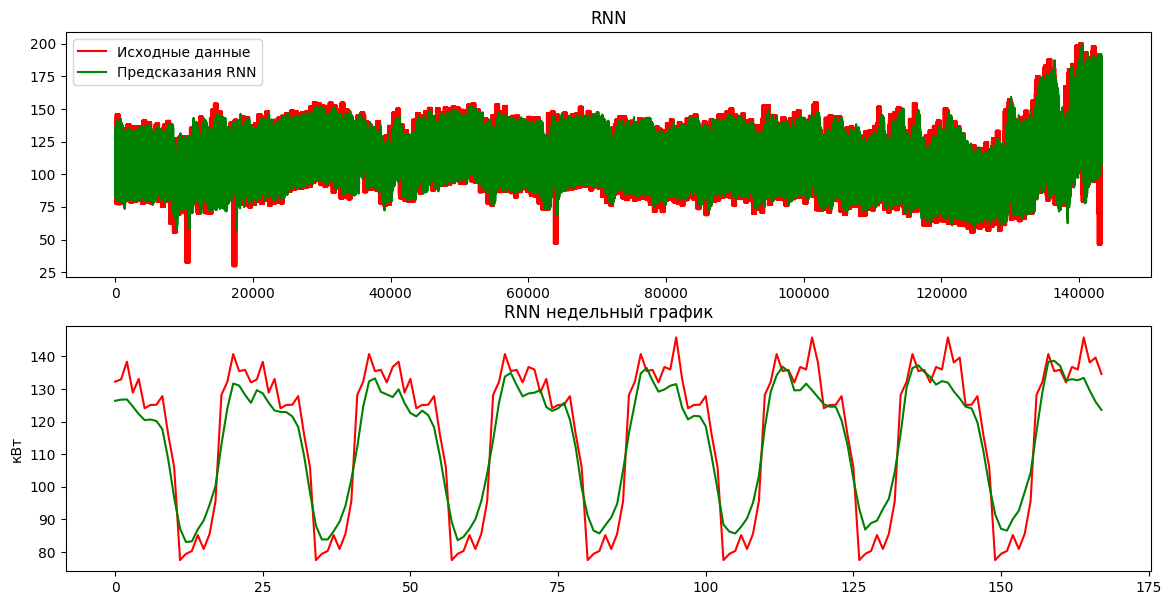

In [290]:
plt.figure(figsize=(14, 7))
plt.subplot(2,1,1)
plt.plot(res_rnn['Исходные данные'], label='Исходные данные', color='red')
plt.plot(res_rnn['Предсказания RNN'], label='Предсказания RNN', color='green')
plt.title('RNN')
plt.legend()
plt.subplot(2,1,2)
plt.plot(res_rnn['Исходные данные'][:168], label='Исходные данные', color='red')
plt.plot(res_rnn['Предсказания RNN'][:168], label='Предсказания RNN', color='green')
plt.title('RNN недельный график')
plt.ylabel('кВт')

plt.show()

In [217]:
#данные с прогнозом трейдера
traider_data = pd.read_excel('/content/traider_data.xlsx')
traider_data.set_index('time', inplace=True)
traider_data.shape

(1464, 1)

In [218]:
traider_data_array = np.array(traider_data['power'])


In [219]:
n_samples = len(traider_data_array) - time_steps - forecast_horizon + 1
y_traider = np.array([traider_data_array[i + time_steps:i + time_steps + forecast_horizon] for i in range(n_samples)])

In [291]:
size_interval = len(traider_data_array)

res_rnn_traider = pd.DataFrame({'Предсказания RNN': predict_rnn.flatten()[-size_interval:],
                                'Исходные данные': np.array(y_test).flatten()[-size_interval:],
                                'Прогноз трейдера' : np.array(y_traider).flatten()[-size_interval:]})

In [292]:
res_rnn_traider.describe().T

,count,mean,std,min,25%,50%,75%,max
Предсказания RNN,1464.0,153.709671,31.569103,93.820007,119.862312,169.150513,180.856983,192.307281
Исходные данные,1464.0,150.784672,39.923554,46.200000,111.660000,168.780000,183.420000,198.120000
Прогноз трейдера,1464.0,151.058060,35.406767,91.000000,106.750000,170.000000,183.000000,189.000000


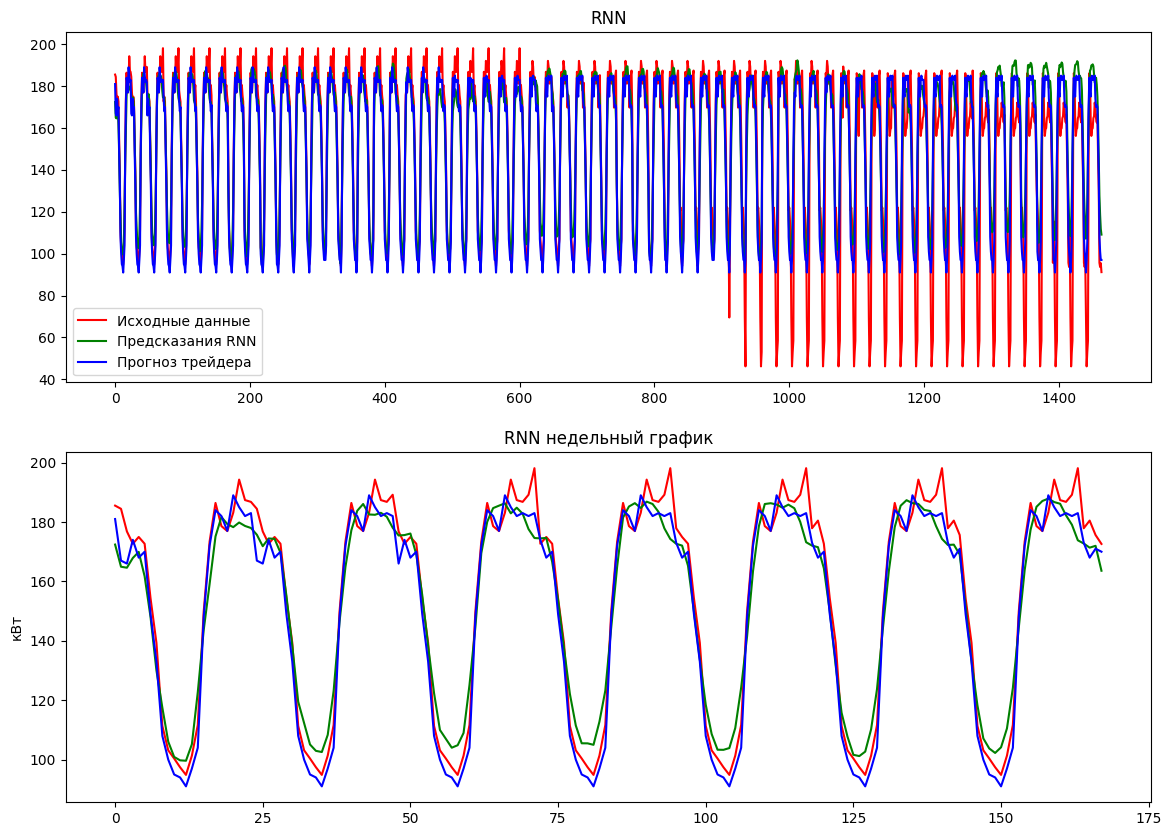

In [293]:
plt.figure(figsize=(14, 10))
plt.subplot(2,1,1)
plt.plot(res_rnn_traider['Исходные данные'], label='Исходные данные', color='red')
plt.plot(res_rnn_traider['Предсказания RNN'], label='Предсказания RNN', color='green')
plt.plot(res_rnn_traider['Прогноз трейдера'], label='Прогноз трейдера', color='blue')
plt.title('RNN')
plt.legend()
plt.subplot(2,1,2)
plt.plot(res_rnn_traider['Исходные данные'][:168], label='Исходные данные', color='red')
plt.plot(res_rnn_traider['Предсказания RNN'][:168], label='Предсказания RNN', color='green')
plt.plot(res_rnn_traider['Прогноз трейдера'][:168], label='Прогноз трейдера', color='blue')
plt.title('RNN недельный график')
plt.ylabel('кВт')

plt.show()

Попробуем модель на новых данных. Возьмем профиль мощности того же объекта за 01.07.24 - 07.07.24 и на основании первых 6 дней сделаем прогноз на сутки вперед (07.07.2024)

In [223]:
data_new = pd.read_excel('/content/power data new.xls')
data_new.set_index('time', inplace=True)

In [225]:
#преобразуем данные для входа
data_array = np.array(data_new['power'])
X = sliding_window_view(data_array[:144], window_shape=(time_steps,))[:-forecast_horizon]
X = X.reshape(-1, time_steps, 1)


In [294]:
predict_new = model_rnn.predict(X)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


In [295]:
predict_new[0]

array([ 80.28977 ,  86.87096 ,  98.43504 , 113.331024, 129.64903 ,
       139.76295 , 146.49431 , 147.1215  , 149.38174 , 150.41925 ,
       151.45981 , 151.1625  , 148.32104 , 143.95932 , 143.06955 ,
       141.53714 , 136.1158  , 128.62791 , 116.915924, 100.95218 ,
        89.23224 ,  83.52406 ,  79.76981 ,  79.717476], dtype=float32)

In [228]:
d = data_array[144:]

In [296]:
res_new = pd.DataFrame({'Предсказания RNN': predict_new.flatten()[:24], 'Исходные данные': d.flatten()})
res_new

,Предсказания RNN,Исходные данные
0,80.289772,84.84
1,86.870956,86.76
2,98.435043,96.90
3,113.331024,126.78
4,129.649033,152.64
5,139.762955,158.82
6,146.494308,160.98
7,147.121506,156.48
8,149.381744,163.20
9,150.419250,164.82


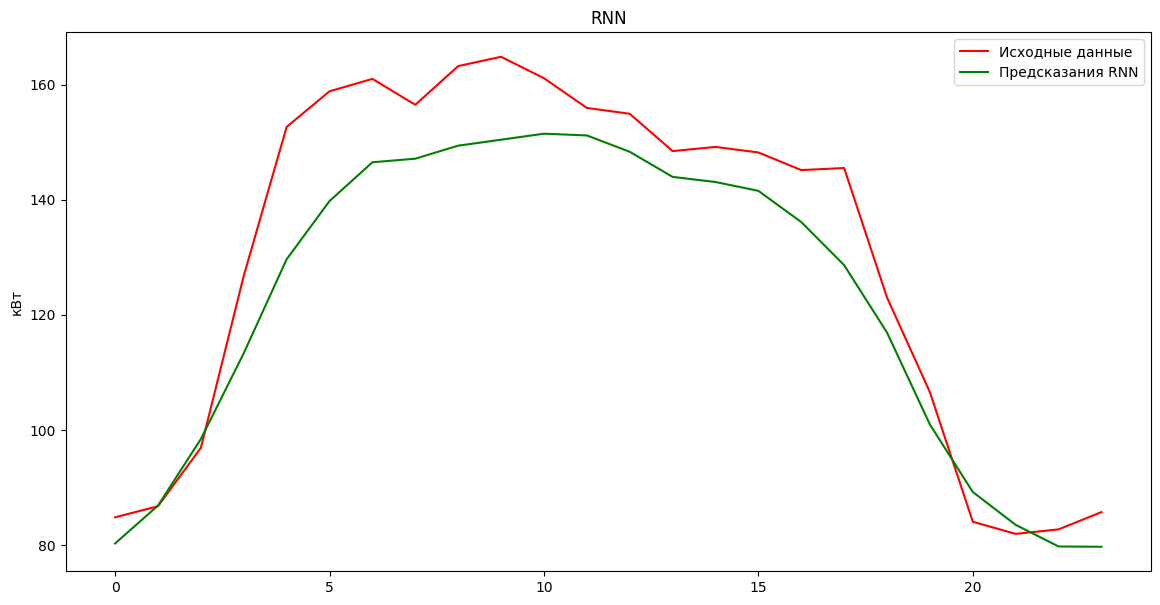

In [297]:
plt.figure(figsize=(14, 7))
plt.plot(res_new['Исходные данные'], label='Исходные данные', color='red')
plt.plot(res_new['Предсказания RNN'], label='Предсказания RNN', color='green')
plt.title('RNN')
plt.legend()
plt.ylabel('кВт')

plt.show()

RMSE: 8.71

в среднем ошибка прогноза составляет около 8.71 единиц. Низкое значение RMSE свидетельствует о том, что модель хорошо справляется с предсказанием значений временного ряда.

MAE: 6.51

средняя абсолютная ошибка предсказаний составляет 6.51 единиц. MAE является более интерпретируемой метрикой, так как она не зависит от квадрата ошибок, и в данном случае также указывает на хорошую производительность модели.

MAPE: 5.79%

в среднем относительная ошибка модели составляет 5.79%. Это приемлемый уровень ошибки, который говорит о том, что модель может быть использована для прогнозирования, особенно если временной ряд не имеет резких колебаний или аномалий.

R²: 0.83

указывает на то, что 83% изменения в целевом переменном временном ряде объясняется выбранной моделью. Это достаточно высокий уровень объясняющей силы модели, что указывает на её способность улавливать основные факторы, влияющие на прогнозируемую переменную.

В целом, метрики RMSE, MAE, MAPE и R² указывают на то, что модель обладает хорошими показателями точности и может быть использована для прогнозирования. RMSE и MAE показывают приемлемые уровни ошибки, а R² свидетельствует о высоком уровне объясняющей силы модели. Так как точность прогноза модели очень близка к точности прогноза трейдера, то модель на основе реккурентной нейросети может стать не плохим решением для автоматизации процесса планирования на сутки вперед при работе на ОРЭМ для объектов со стабильным графиком потребления.